['sweing' 'finishing']
['date', 'quarter', 'department', 'day', 'team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers', 'actual_productivity']

Encoded Data:
   team  targeted_productivity    smv  over_time  incentive  idle_time  \
0     8                   0.80  26.16       7080         98        0.0   
1     1                   0.75   3.94        960          0        0.0   
2    11                   0.80  11.41       3660         50        0.0   
3    12                   0.80  11.41       3660         50        0.0   
4     6                   0.80  25.90       1920         50        0.0   

   idle_men  no_of_style_change  no_of_workers  actual_productivity  ...  \
0         0                   0           59.0             0.940725  ...   
1         0                   0            8.0             0.886500  ...   
2         0                   0           30.5             0.800570  ...   
3         0 

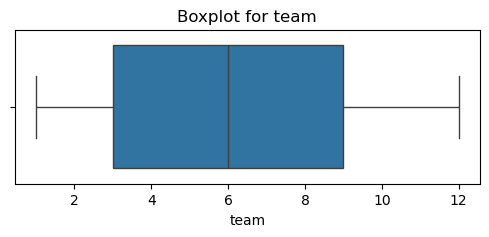

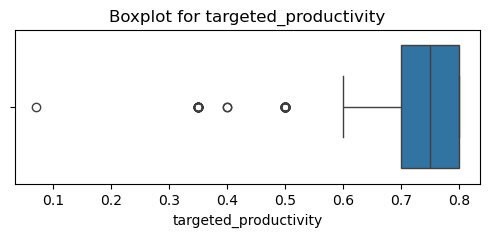

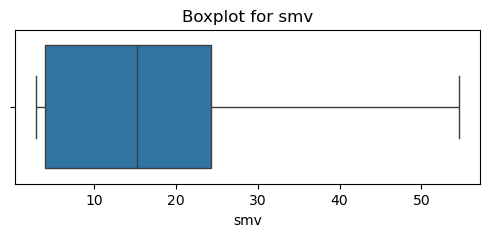

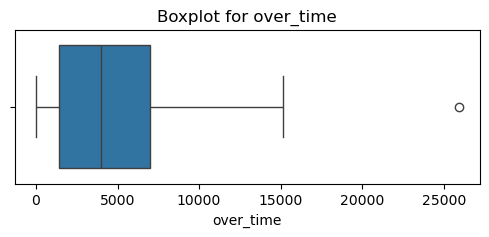

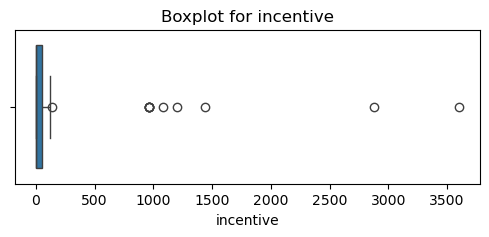

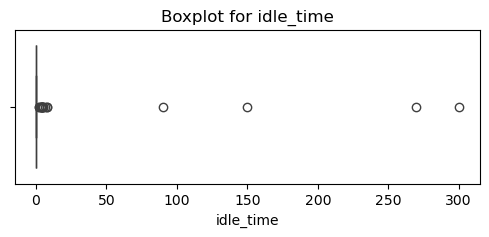

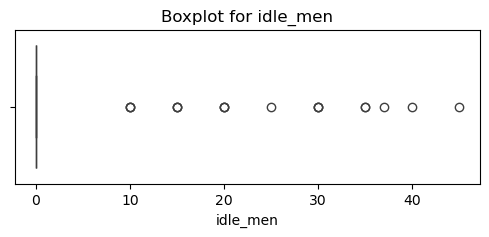

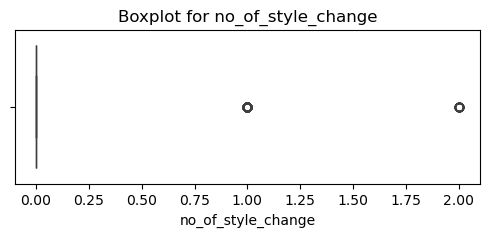

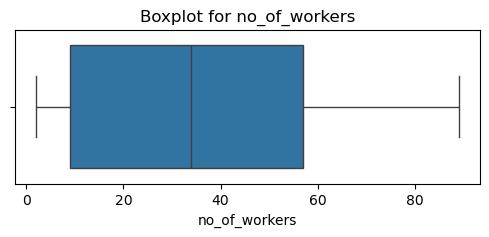

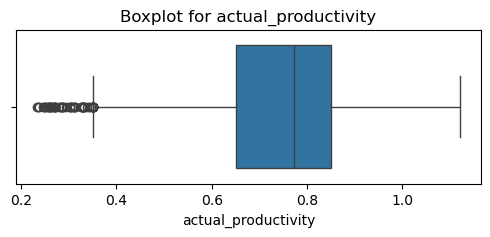


✅ Outliers handled using IQR method — values replaced with **median**.

Before OverSampling, counts of label 'Success': 608
Before OverSampling, counts of label 'Fail': 229
After OverSampling, counts of label 'Success': 608
After OverSampling, counts of label 'Fail': 608


In [10]:
import pandas as pd
file_path = r'C:\Users\ADMIN\Downloads\garments_worker_productivity.csv' 
df=pd.read_csv(file_path)
import matplotlib.pyplot as plt
import seaborn as sns
# Remove leading/trailing spaces in the 'department' column
df['department'] = df['department'].str.strip()

# Get unique values after cleaning
unique_departments = df['department'].unique()

df.head(5)
# Convert 'date' to datetime just in case
df['date'] = pd.to_datetime(df['date'])

# Extract month and day only (to compare mm-dd)
df['mmdd'] = df['date'].dt.strftime('%d-%m')

# Define custom quarters
def assign_custom_quarter(mmdd):
    if '01-01' <= mmdd <= '03-31':
        return 'Q1'
    elif '04-01' <= mmdd <= '06-30':
        return 'Q2'
    elif '07-01' <= mmdd <= '09-30':
        return 'Q3'
    else:
        return 'Q4'

# Apply function to every row
df['quarter'] = df['mmdd'].apply(assign_custom_quarter)

# Optional: Drop mmdd helper column
df.drop(columns=['mmdd'], inplace=True)



# Remove leading/trailing spaces in the 'department' column
df['department'] = df['department'].str.strip()

# Get unique values after cleaning
unique_departments = df['department'].unique()

print(unique_departments)
print(df.columns.tolist())
df.drop(['wip'],axis=1 ,inplace =True)
from sklearn.preprocessing import LabelEncoder

# Create 'success' column
df['success'] = df['actual_productivity'] > df['targeted_productivity']
df['success'] = df['success'].apply(lambda x: 'Success' if x else 'Fail')
# Convert categorical variables to numerical values using one-hot encoding
df = df.drop(columns=['date'])
data_encoded = pd.get_dummies(df, columns=['quarter', 'department', 'day'])
print("\nEncoded Data:")
print(data_encoded.head())
from sklearn.preprocessing import MinMaxScaler

# Step 1: Identify numerical columns
numerical_features = ['team', 'targeted_productivity', 'smv','over_time','incentive',
                      'idle_time','idle_men','no_of_style_change', 'no_of_workers', 'actual_productivity']

# Step 2: Visualize outliers using boxplots (optional)
import seaborn as sns
import matplotlib.pyplot as plt

for feature in numerical_features:
    plt.figure(figsize=(6, 2))
    sns.boxplot(x=data_encoded[feature])
    plt.title(f'Boxplot for {feature}')
    plt.show()

# Step 3: Apply IQR and replace outliers with median
for feature in numerical_features:
    Q1 = data_encoded[feature].quantile(0.25)
    Q3 = data_encoded[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    median_val = data_encoded[feature].median()
    
    # Replace outliers with median
    data_encoded[feature] = data_encoded[feature].apply(
        lambda x: median_val if x < lower_bound or x > upper_bound else x
    )

print("\n✅ Outliers handled using IQR method — values replaced with **median**.\n")
# Split features and target
X = data_encoded.drop(columns=['success'])
y = data_encoded['success']

# Encode target
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

print("Before OverSampling, counts of label 'Success':", sum(y_train == 1))
print("Before OverSampling, counts of label 'Fail':", sum(y_train == 0))
from imblearn.over_sampling import SMOTE
# Apply SMOTE to the training data
sm = SMOTE(random_state=2)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train.ravel())

# Display class distribution after SMOTE
print("After OverSampling, counts of label 'Success': {}".format(sum(y_train_smote == 1)))
print("After OverSampling, counts of label 'Fail': {}".format(sum(y_train_smote == 0)))

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import time
def knn_model(X_train_smote, y_train_smote, X_test, y_test, k=5):
    # Initialize the k-Nearest Neighbors classifier with a default k
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Measure training time
    start_time = time.time()
    
    # Train the model
    knn.fit(X_train_smote, y_train_smote)
    
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time (KNN before tuning): {training_time:.4f} seconds")
    
    # Make predictions on the test set
    y_pred = knn.predict(X_test)
    
    # Evaluate the model
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print("\nAccuracy Score:")
    print(accuracy_score(y_test, y_pred))
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Adopted', 'Adopted'])
    disp.plot(cmap='Blues', values_format='d')
    
    # Show plot
    plt.title('Confusion Matrix')
    plt.show()
    
    # Calculate ROC curve and AUC
    y_prob = knn.predict_proba(X_test)[:, 1]  # Get the probabilities of the positive class
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    print(f"AUC: {roc_auc}")
    
    return fpr, tpr, roc_auc


In [20]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

def knn_after_tuning(X_train_smote, y_train_smote, X_test, y_test):
    # Define the parameter grid
    param_grid = {
        'n_neighbors': range(1, 31),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }
    
    # Initialize the k-Nearest Neighbors classifier
    knn = KNeighborsClassifier()
    
    # Measure training time
    start_time = time.time()
    
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train_smote, y_train_smote)
    
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time (KNN after tuning): {training_time:.4f} seconds")
    
    # Best parameters
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    print(f"Best Parameters: {best_params}")
    
    # Make predictions on the test set
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]
    
    # Evaluate the model
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print("\nAccuracy Score:")
    print(accuracy_score(y_test, y_pred))

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Loss', 'Success'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    print(fpr)
    print(tpr)
    roc_auc = auc(fpr, tpr)
    
    print(f"AUC: {roc_auc}")
    return fpr, tpr, roc_auc


Training time (KNN before tuning): 0.0064 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.65      0.61        99
           1       0.86      0.82      0.84       261

    accuracy                           0.78       360
   macro avg       0.72      0.74      0.73       360
weighted avg       0.78      0.78      0.78       360


Accuracy Score:
0.775


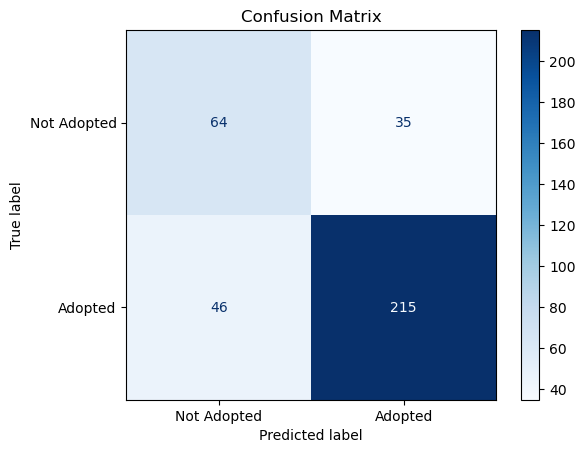

AUC: 0.7915166995626765
Training time (KNN after tuning): 31.9178 seconds
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.62      0.62        99
           1       0.85      0.85      0.85       261

    accuracy                           0.79       360
   macro avg       0.74      0.74      0.74       360
weighted avg       0.79      0.79      0.79       360


Accuracy Score:
0.7888888888888889


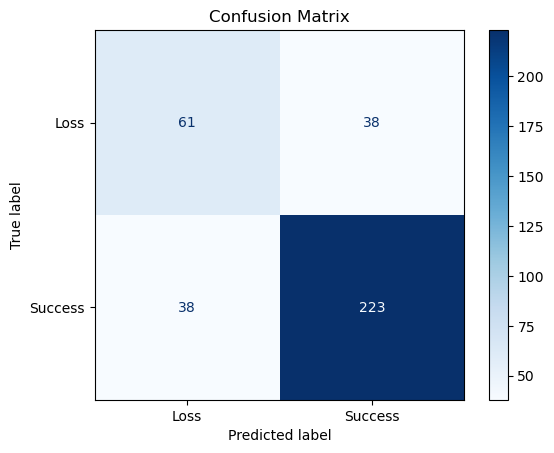

[0.         0.38383838 1.        ]
[0.         0.85440613 1.        ]
AUC: 0.7352838732149077


In [21]:
fpr1, tpr1, auc_knn1 = knn_model(X_train_smote, y_train_smote, X_test, y_test)
fpr2, tpr2, auc_knn2 = knn_after_tuning(X_train_smote, y_train_smote, X_test, y_test)

In [22]:
from sklearn.naive_bayes import GaussianNB

def nb_model(X_train_smote, y_train_smote, X_test, y_test):
    # Initialize the Naive Bayes classifier
    nb = GaussianNB()
    
    # Measure training time
    start_time = time.time()
    
    # Train the model
    nb.fit(X_train_smote, y_train_smote)
    
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time (Naive Bayes before tuning): {training_time:.4f} seconds")
    
    # Make predictions on the test set
    y_pred = nb.predict(X_test)
    y_pred_proba = nb.predict_proba(X_test)[:, 1]
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print("\nAccuracy Score:")
    print(accuracy_score(y_test, y_pred))
    
    # Evaluate the model
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Loss', 'Success'])
    disp.plot(cmap='Blues', values_format='d')
    
    # Show plot
    plt.title('Confusion Matrix')
    plt.show()
    
    # Compute AUC and ROC curve
    auc = roc_auc_score(y_test, y_pred_proba)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    print(auc)
    
    return fpr, tpr, auc

In [23]:
from sklearn.metrics import roc_auc_score

def nb_after_tuning(X_train_smote, y_train_smote, X_test, y_test):
    # Initialize the Naive Bayes classifier
    nb = GaussianNB()

    # Define the hyperparameter grid
    param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]}
    
    # Measure training time
    start_time = time.time()

    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=nb, param_grid=param_grid, cv=5, scoring='accuracy')

    # Fit GridSearchCV
    grid_search.fit(X_train_smote, y_train_smote)
    
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time (Naive Bayes after tuning): {training_time:.4f} seconds")

    # Print the best hyperparameters
    print(f"Best hyperparameters: {grid_search.best_params_}")

    # Use the best estimator to make predictions
    best_nb = grid_search.best_estimator_
    y_pred = best_nb.predict(X_test)
    y_pred_proba = best_nb.predict_proba(X_test)[:, 1]
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("\nAccuracy Score:")
    print(accuracy_score(y_test, y_pred))

    # Evaluate the model
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Loss', 'Success'])
    disp.plot(cmap='Blues', values_format='d')

    # Show plot
    plt.title('Confusion Matrix')
    plt.show()

    # Compute AUC and ROC curve
    auc = roc_auc_score(y_test, y_pred_proba)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    print(fpr)
    print(tpr)

    print(auc)

    return fpr, tpr, auc

Training time (Naive Bayes before tuning): 0.0072 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.75      0.57        99
           1       0.87      0.67      0.76       261

    accuracy                           0.69       360
   macro avg       0.67      0.71      0.66       360
weighted avg       0.76      0.69      0.71       360


Accuracy Score:
0.6888888888888889


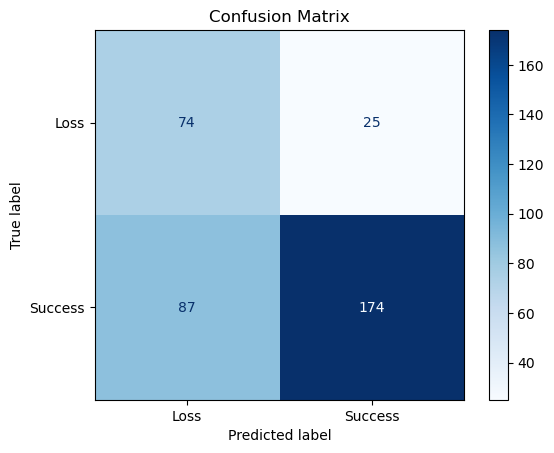

0.83331398273927
Training time (Naive Bayes after tuning): 0.7097 seconds
Best hyperparameters: {'var_smoothing': 1e-09}

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.75      0.57        99
           1       0.87      0.67      0.76       261

    accuracy                           0.69       360
   macro avg       0.67      0.71      0.66       360
weighted avg       0.76      0.69      0.71       360


Accuracy Score:
0.6888888888888889


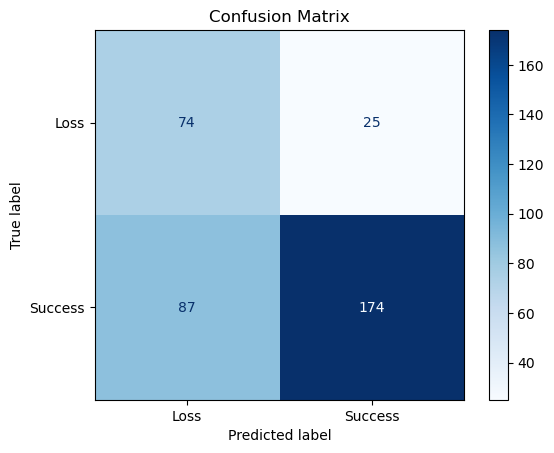

[0.         0.         0.         0.01010101 0.01010101 0.03030303
 0.03030303 0.04040404 0.04040404 0.05050505 0.05050505 0.06060606
 0.06060606 0.07070707 0.07070707 0.09090909 0.09090909 0.1010101
 0.1010101  0.11111111 0.11111111 0.12121212 0.12121212 0.13131313
 0.13131313 0.14141414 0.14141414 0.16161616 0.16161616 0.17171717
 0.17171717 0.18181818 0.18181818 0.2020202  0.2020202  0.21212121
 0.21212121 0.25252525 0.25252525 0.27272727 0.27272727 0.29292929
 0.29292929 0.3030303  0.3030303  0.32323232 0.32323232 0.33333333
 0.33333333 0.34343434 0.34343434 0.36363636 0.36363636 0.37373737
 0.37373737 0.38383838 0.38383838 0.39393939 0.39393939 0.4040404
 0.4040404  0.42424242 0.42424242 0.44444444 0.44444444 0.47474747
 0.47474747 0.51515152 0.51515152 0.53535354 0.53535354 0.54545455
 0.54545455 0.58585859 0.58585859 0.5959596  0.5959596  0.65656566
 0.65656566 0.70707071 0.70707071 0.86868687 0.86868687 1.        ]
[0.         0.03065134 0.14942529 0.14942529 0.2835249  0.28352

In [24]:
fpr1, tpr1, auc_nb1 = nb_model(X_train_smote, y_train_smote, X_test, y_test)
fpr2, tpr2, auc_nb2 = nb_after_tuning(X_train_smote, y_train_smote, X_test, y_test)

In [1]:
def compute_kappa(confusion_matrix):
    """
    Computes Cohen's Kappa statistic from a 2x2 confusion matrix.

    Parameters:
    confusion_matrix: list of lists or 2D array
        A 2x2 matrix in the form:
            [[TP (a), FN (b)],
             [FP (c), TN (d)]]

    Returns:
    kappa: float
        The computed Cohen's Kappa statistic.
    """
    a = confusion_matrix[0][0]  # True negatives or TP for class 0
    b = confusion_matrix[0][1]  # False negatives
    c = confusion_matrix[1][0]  # False positives
    d = confusion_matrix[1][1]  # True positives

    N = a + b + c + d

    # Observed agreement
    Po = (a + d) / N

    # Expected agreement
    actual_0 = a + b
    actual_1 = c + d
    pred_0 = a + c
    pred_1 = b + d

    Pe = ((actual_0 * pred_0) + (actual_1 * pred_1)) / (N ** 2)

    # Kappa calculation
    kappa = (Po - Pe) / (1 - Pe)
    return round(kappa, 4)


In [3]:
conf_matrix = [
    [71, 28],  # 50 TP, 10 FN
    [26,  235]   # 5 FP, 35 TN
]
kappa_score = compute_kappa(conf_matrix)
print(" LogisticKappa Score:", kappa_score)


 LogisticKappa Score: 0.6215


In [4]:
conf_matrix = [
    [61, 38],  # 50 TP, 10 FN
    [38,  233]   # 5 FP, 35 TN
]
kappa_score = compute_kappa(conf_matrix)
print(" kNN Kappa Score:", kappa_score)

 LogisticKappa Score: 0.4759


In [6]:
conf_matrix = [
    [74, 25],  # 50 TP, 10 FN
    [87,  174]   # 5 FP, 35 TN
]
kappa_score = compute_kappa(conf_matrix)
print(" Nb Kappa Score:", kappa_score)

 Nb Kappa Score: 0.3467


In [7]:
conf_matrix = [
    [88, 11],  # 50 TP, 10 FN
    [17,  244]   # 5 FP, 35 TN
]
kappa_score = compute_kappa(conf_matrix)
print(" Random Forest Kappa Score:", kappa_score)

 Random Forest Kappa Score: 0.8085


In [8]:
conf_matrix = [
    [92, 7],  # 50 TP, 10 FN
    [11,  250]   # 5 FP, 35 TN
]
kappa_score = compute_kappa(conf_matrix)
print(" Decision Tree Kappa Score:", kappa_score)

 Decision Tree Kappa Score: 0.8762
